# Part1: association rules

## import libraries

In [9]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import LabelEncoder

## Load data

In [2]:
aisles = pd.read_csv('dataset/aisles.csv')
departments = pd.read_csv('dataset/departments.csv')
orders = pd.read_csv('dataset/orders.csv')
products = pd.read_csv('dataset/products.csv')
order_products_prior = pd.read_csv('dataset/order_products__prior.csv')
order_products_train = pd.read_csv('dataset/order_products__train.csv')
print('data loaded')

data loaded


## explore data

In [3]:
print('aisles head:')
print(aisles.head())

print('\ndepartments head:')
print(departments.head())

print('\norders head:')
print(orders.head())

print('\nproducts head:')
print(products.head())

print('\norder_products_prior head:')
print(order_products_prior.head())

print('\norder_products_train head:')
print(order_products_train.head())

aisles head:
   aisle_id                       aisle
0         1       prepared soups salads
1         2           specialty cheeses
2         3         energy granola bars
3         4               instant foods
4         5  marinades meat preparation

departments head:
   department_id department
0              1     frozen
1              2      other
2              3     bakery
3              4    produce
4              5    alcohol

orders head:
   order_id  user_id eval_set  order_number  order_dow  order_hour_of_day  \
0   2539329        1    prior             1          2                  8   
1   2398795        1    prior             2          3                  7   
2    473747        1    prior             3          3                 12   
3   2254736        1    prior             4          4                  7   
4    431534        1    prior             5          4                 15   

   days_since_prior_order  
0                     NaN  
1                    15.0  

In [4]:
print('\naisles shape: ', aisles.shape)
print('\ndepartments shape: ', departments.shape)
print('\norders shape: ', orders.shape)
print('\nproducts shape: ', products.shape)
print('\norder_products_prior shape: ', order_products_prior.shape)
print('\norder_products_train shape: ', order_products_train.shape)


aisles shape:  (134, 2)

departments shape:  (21, 2)

orders shape:  (3421083, 7)

products shape:  (49688, 4)

order_products_prior shape:  (32434489, 4)

order_products_train shape:  (1384617, 4)


## preprocessing data

In [5]:
order_products = pd.concat([order_products_prior, order_products_train])
full_data = order_products.merge(products, on='product_id', how='left')
print('\nfull data shape: ', full_data.shape)
print('\nfull data head:')
print(full_data.head())


full data shape:  (33819106, 7)

full data head:
   order_id  product_id  add_to_cart_order  reordered           product_name  \
0         2       33120                  1          1     Organic Egg Whites   
1         2       28985                  2          1  Michigan Organic Kale   
2         2        9327                  3          0          Garlic Powder   
3         2       45918                  4          1         Coconut Butter   
4         2       30035                  5          0      Natural Sweetener   

   aisle_id  department_id  
0        86             16  
1        83              4  
2       104             13  
3        19             13  
4        17             13  


In [6]:
sample_orders = orders['order_id'].sample(n=100000, random_state=42)
sample_data = full_data[full_data['order_id'].isin(sample_orders)]
transaction_df = sample_data.groupby('order_id')['product_name'].apply(list)
print('transaction head:')
print(transaction_df.head())

transaction head:
order_id
33     [Gluten Free Mushroom Risotto Bowl, Cold-Brew ...
47     [Strawberries, Organic Blueberries, Raspberrie...
181    [Organic Broccoli Florets, Double Concentrated...
193    [Organic Distilled White Vinegar, Organic Gree...
265    [Natural Free & Clear Dish Liquid, Organic Who...
Name: product_name, dtype: object


## apriori algorithm

In [7]:
min_support = 0.01
te = TransactionEncoder()
te_ary = te.fit(transaction_df).transform(transaction_df)
df_encoded = pd.DataFrame(te_ary, columns=te.columns_)
frequent_itemsets = apriori(df_encoded, min_support=min_support, use_colnames=True)
print('number of frequent_itemsets: ', len(frequent_itemsets))
print('frequent_items head:')
print(frequent_itemsets.head())


number of frequent_itemsets:  118
frequent_items head:
    support                    itemsets
0  0.011840    (100% Raw Coconut Water)
1  0.018562    (100% Whole Wheat Bread)
2  0.011411       (2% Reduced Fat Milk)
3  0.026551  (Apple Honeycrisp Organic)
4  0.021167                 (Asparagus)


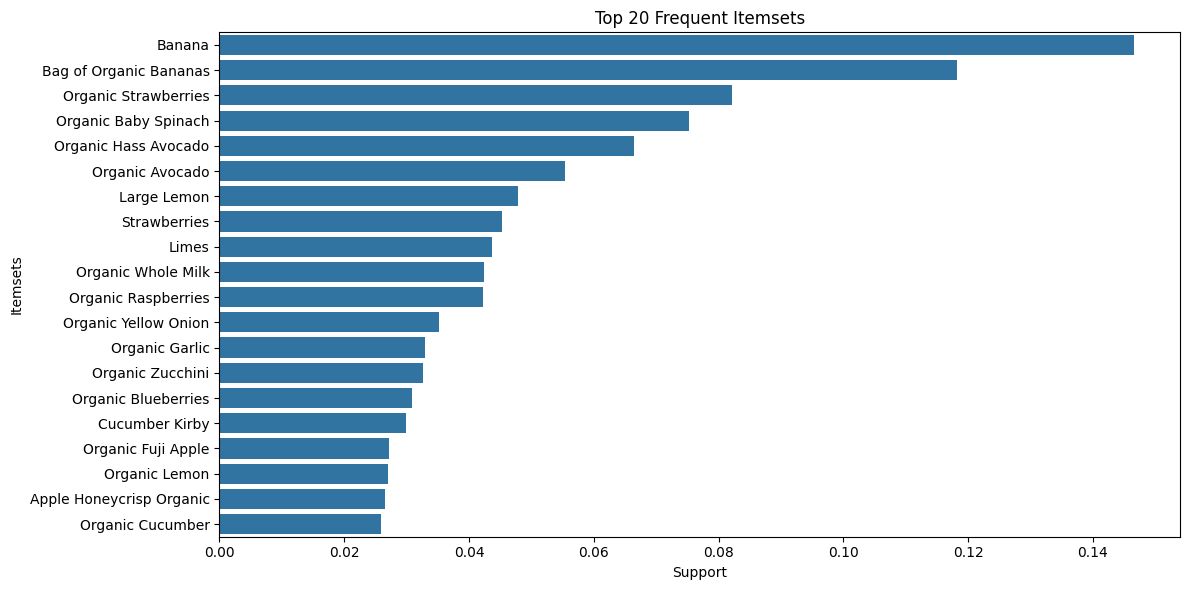

In [10]:
frequent_items = frequent_itemsets.sort_values(by="support", ascending=False).head(20)
plt.figure(figsize=(12, 6))
sns.barplot(x='support', y=frequent_items['itemsets'].apply(lambda x: ', '.join(list(x))), data=frequent_items)
plt.title("Top 20 Frequent Itemsets")
plt.xlabel("Support")
plt.ylabel("Itemsets")
plt.tight_layout()
plt.show()

## extract association rules

In [11]:
min_confidence = 0.2
rules = association_rules(frequent_itemsets, metric='confidence', min_threshold=min_confidence)
rules = rules.sort_values('lift', ascending=False)
print('\nnumber of association_rules: ', len(rules))
print('association_rules head:')
print(rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head())


number of association_rules:  12
association_rules head:
               antecedents               consequents   support  confidence  \
11   (Organic Raspberries)    (Organic Strawberries)  0.010696    0.252899   
8     (Organic Fuji Apple)                  (Banana)  0.010839    0.397974   
2    (Organic Raspberries)  (Bag of Organic Bananas)  0.012555    0.296860   
1   (Organic Hass Avocado)  (Bag of Organic Bananas)  0.019195    0.289121   
4         (Cucumber Kirby)                  (Banana)  0.010154    0.340411   

        lift  
11  3.077540  
8   2.714012  
2   2.509631  
1   2.444211  
4   2.321454  


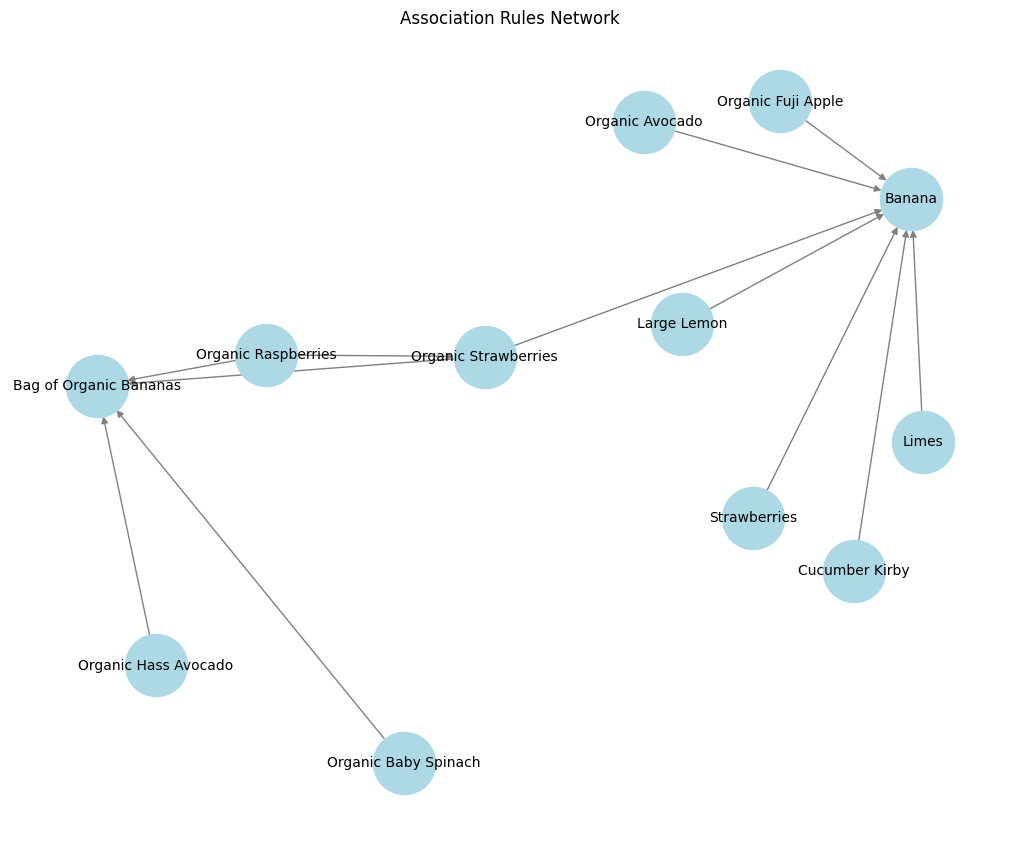

In [12]:
G = nx.DiGraph()
for _, row in rules.head(20).iterrows():
    for ant in row['antecedents']:
        for con in row['consequents']:
            G.add_edge(ant, con, weight=row['confidence'])

plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G, k=0.5)
nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=2000, font_size=10)
plt.title("Association Rules Network")
plt.show()

## save result

In [13]:
frequent_itemsets.to_csv('frequent_itemsets.csv', index=False)
rules.to_csv('association_rules.csv', index=False)

# Part2: analys using regression

## preparing features

In [14]:
order_size = order_products.groupby('order_id').size().reset_index(name='total_products')
orders_ext = pd.merge(orders, order_size, on='order_id', how='left')
user_stats = orders_ext.groupby('user_id').agg({
    'order_number': 'max',
    'days_since_prior_order': 'mean',
    'total_products': 'mean'
}).rename(columns={
    'order_number': 'total_orders',
    'days_since_prior_order': 'avg_gap_days',
    'total_products': 'avg_order_size'
}).reset_index()
orders_features = pd.merge(orders_ext, user_stats, on='user_id')
orders_features = orders_features.dropna()
print('orders_features shape: ', orders_features.shape)
print('orders_features head:')
print(orders_features.head())

orders_features shape:  (3139874, 11)
orders_features head:
   order_id  user_id eval_set  order_number  order_dow  order_hour_of_day  \
1   2398795        1    prior             2          3                  7   
2    473747        1    prior             3          3                 12   
3   2254736        1    prior             4          4                  7   
4    431534        1    prior             5          4                 15   
5   3367565        1    prior             6          2                  7   

   days_since_prior_order  total_products  total_orders  avg_gap_days  \
1                    15.0             6.0            11          19.0   
2                    21.0             5.0            11          19.0   
3                    29.0             5.0            11          19.0   
4                    28.0             8.0            11          19.0   
5                    19.0             4.0            11          19.0   

   avg_order_size  
1        6.363636 

## regression model for number of products prediction

In [15]:
X1 = orders_features[['order_hour_of_day', 'avg_gap_days', 'total_orders']]
y1 = orders_features['total_products']
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.2, random_state=42)
model1 = LinearRegression()
model1.fit(X_train1, y_train1)
y_pred1 = model1.predict(X_test1)
mse1 = mean_squared_error(y_test1, y_pred1)
print(f'number of products MSE: {mse1}, RMSE: {np.sqrt(mse1)}')


number of products MSE: 57.18450692174338, RMSE: 7.5620438323077295


## regression model for orders interval prediction

In [29]:
X2 = orders_features[['order_hour_of_day', 'avg_order_size', 'total_orders']]
y2 = orders_features['days_since_prior_order']
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2, random_state=42)
model2 = Ridge()
model2.fit(X_train2, y_train2)
y_pred2 = model2.predict(X_test2)
mse2 = mean_squared_error(y_test2, y_pred2)
print(f'orders interval MSE: {mse2}, RMSE: {np.sqrt(mse2)}')

orders interval MSE: 62.886906727416296, RMSE: 7.930126526570449


# Part3: Naive Bayes Classification

## product repurchase prediction

In [30]:
df = pd.merge(order_products, orders[['order_id', 'user_id', 'order_hour_of_day', 'days_since_prior_order']], on='order_id')
df = df.fillna(0)

X = df[['order_hour_of_day', 'days_since_prior_order']]
y = df['reordered']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = GaussianNB()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))

Accuracy: 0.5954900942100487
Precision: 0.6068421031084837
Recall: 0.8919003684624983
F1 Score: 0.7222624375136089


## customer classification

In [31]:
prod_dept = pd.merge(products, departments, on='department_id')
order_dept = pd.merge(order_products, prod_dept, on='product_id')
order_dept_user = pd.merge(order_dept, orders[['order_id', 'user_id']], on='order_id')

user_dept_pref = order_dept_user.groupby(['user_id', 'department'])['product_id'].count().reset_index()
user_dept_pref = user_dept_pref.sort_values('product_id', ascending=False).drop_duplicates('user_id')
user_dept_pref = user_dept_pref.rename(columns={'department': 'fav_department'})

user_features = orders.groupby('user_id').agg({
    'order_number': 'max',
    'days_since_prior_order': 'mean'
}).reset_index()

user_data = pd.merge(user_features, user_dept_pref, on='user_id')
X = user_data[['order_number', 'days_since_prior_order']]
y = LabelEncoder().fit_transform(user_data['fav_department'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = GaussianNB()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("Customer Segment Classification Accuracy:", accuracy_score(y_test, y_pred))

Customer Segment Classification Accuracy: 0.5794335871199263
